In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sagemaker
import boto3
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns',None) # To display all columns
pd.set_option('display.max_rows',None) # To display all columns
client = boto3.client('s3')
import feather
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from functools import reduce
from datetime import datetime
from dateutil.relativedelta import relativedelta

## LOADING DATAFRAMES

In [2]:
df1 = pd.read_feather('FinalData.ftr')
df2 = pd.read_feather('Dataframe80.ftr')
dfu = pd.read_feather('s3://haseebdata/Dataset/Users.ftr')
dfq = pd.read_feather('s3://haseebdata/Dataset/dfq.ftr')
Repeat=pd.read_feather('RepeatedQuestion.ftr')

## DF1 = MAIN COMPLETE DATAFRAME

In [3]:
df1.head()

,index,timestamp,solving_id,question_id,user_answer,elapsed_time,user_iD,correct_answer,bundle_id,explanation_id,deployed_at,correct
0,0,1565096190868,1,5012,b,38.0,1,c,3544,3544,2019-09-17 02:43:28.616,0.0
1,1,1565096221062,2,4706,c,24.0,1,c,3238,3238,2019-10-30 05:34:30.723,1.0
2,2,1565096293432,3,4366,b,68.0,1,b,2898,2898,2019-10-30 05:37:51.451,1.0
3,3,1565096339668,4,4829,a,42.0,1,c,3361,3361,2019-06-24 09:24:51.347,0.0
4,4,1565096401774,5,6528,b,59.0,1,d,5060,5060,2019-10-17 03:03:15.009,0.0


## DF2 = Percent 80 & above users


In [4]:
df2.head()

,user_iD,question_id,user_answer,correct_answer,correct,elapsed_time,solving_id,explanation_id,bundle_id,timestamp,deployed_at
0,50,3654,d,d,1.0,47.0,1,2186,2186,1540815498477,2019-09-17 02:49:05.091
1,50,898,c,c,1.0,17.0,2,898,898,1540815563576,2017-12-29 15:34:47.831
2,50,3633,c,b,0.0,53.0,3,2165,2165,1540815619061,2019-05-17 12:10:59.583
3,50,5805,a,d,0.0,41.0,4,4337,4337,1540815663799,2018-02-20 05:45:24.616
4,50,5680,d,c,0.0,25.0,5,4212,4212,1540815691595,2019-09-16 12:05:05.072


In [34]:
Z = df2.loc[df2['user_iD']== 50]
len(Z)

8779

## DF3 = Total Questions Count & Unique Questions Count by Each User

In [5]:
df2['new'] = df2['correct'].eq(1) & ~df2.duplicated(['user_iD','question_id','correct'])
df3 = (df2.groupby(['user_iD'])
        .agg(**{'Questions Attempted':('question_id','nunique'),
                'Unique Questions Attempted':('new','sum')})
        .reset_index())

df3.head()

,user_iD,Questions Attempted,Unique Questions Attempted
0,50,4576,4570
1,58,5608,5191
2,98,5399,4731
3,99,48,39
4,103,7,6


In [7]:
df3['user_iD'].nunique()

27884

## DF4 = Percentage of each User based on Unique Questions Attempted.

In [10]:
df_total_questions_attempted = df2.groupby(['user_iD'], as_index=False , sort=False)['question_id'].count()
df_total_questions_attempted = df_total_questions_attempted.rename(columns={'question_id': 'Unique Attempted'})

df_correct = df2[df2['correct']==1].groupby(['user_iD'], as_index=False, sort=False)['question_id'].count()

df_correct = df_correct.rename(columns={'question_id': 'Corrected'})

df_incorrect = df2[df2['correct']==0].groupby(['user_iD'], as_index=False, sort=False)['question_id'].count()

df_incorrect = df_incorrect.rename(columns={'question_id': 'Incorrected'})

dfs = [df_total_questions_attempted, df_correct, df_incorrect]
df_final = reduce(lambda left,right: pd.merge(left,right,on='user_iD'), dfs)

df_final['Percentage'] = (df_final['Corrected'] / df_final['Unique Attempted']) *100

df2['elapsed_time'] * 1000

df2['elapsed_time']= df2.elapsed_time.div(1000)   #DIVDING THE ELAPSED TIME by 1000 to further check the mean elapsed time by each user
Elapsed_time= df2.groupby('user_iD' , sort=False)['elapsed_time'].median()

dfs = [df_final, Elapsed_time]
df4 = reduce(lambda left,right: pd.merge(left,right,on='user_iD'), dfs)

In [14]:
df4['elapsed_time'] = df2['elapsed_time'] * 1000

In [15]:
df4.head()

,user_iD,Unique Attempted,Corrected,Incorrected,Percentage,elapsed_time
0,50,8779,7310,1469,83.266887,47.0
1,58,7216,6568,648,91.019956,17.0
2,98,7032,5965,1067,84.826507,53.0
3,99,48,39,9,81.250000,41.0
4,103,7,6,1,85.714286,25.0


<AxesSubplot:ylabel='Frequency'>

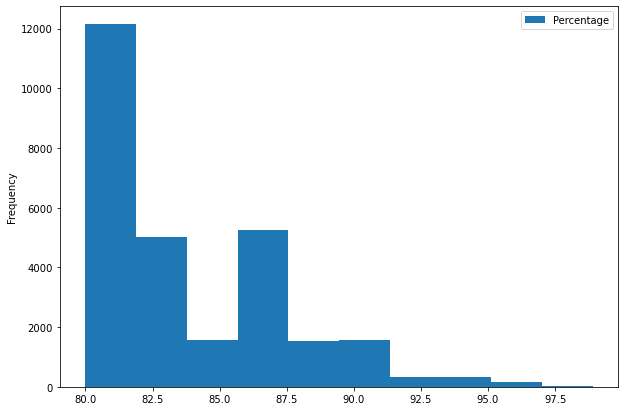

In [20]:
df4.plot( x='Unique Attempted', y='Percentage' , kind ='hist' , figsize = (10,7))

## DF5 = REMOVING DUPLICATE QUESTIONS FROM DATAFRAME 80 

In [21]:
A= df2[0:23085]

In [24]:
B = A[A['correct'].eq(1.0)].groupby(A['user_iD'], as_index=False).agg('max')

In [25]:
B.head()

,user_iD,question_id,user_answer,correct_answer,correct,elapsed_time,solving_id,explanation_id,bundle_id,timestamp,deployed_at,new
0,50,17958,d,d,1.0,0.110,4071,12021,12021,1572091308690,2019-11-18 08:26:53.124,True
1,58,17933,d,d,1.0,0.206,3216,11996,11996,1574757329469,2019-11-18 08:26:53.124,True
2,98,17743,d,d,1.0,0.485,3698,11806,11806,1574755659082,2019-11-18 08:26:53.124,True
3,99,11914,d,d,1.0,0.024,23,8561,8561,1561544586763,2019-10-30 05:28:38.999,True
4,103,6446,d,d,1.0,0.040,7,4978,4978,1561544966654,2019-10-30 05:13:00.056,True


In [26]:
B['correct'].nunique()

1

In [27]:
B['new'].nunique()

1

In [28]:
df_i = B.groupby(['user_iD', 'question_id']).size().reset_index(name='counts')
df_i.head()

,user_iD,question_id,counts
0,50,17958,1
1,58,17933,1
2,98,17743,1
3,99,11914,1
4,103,6446,1


In [29]:
df_i['counts'].nunique()

1

In [30]:
ix = A[A.correct.eq(1)].groupby(['user_iD', 'question_id'])['elapsed_time'].idxmax()
C= A.loc[ix]
C[0:100]

,user_iD,question_id,user_answer,correct_answer,correct,elapsed_time,solving_id,explanation_id,bundle_id,timestamp,deployed_at,new
1818,50,3,b,b,1.0,0.023,1729,3,3,1560337981670,2019-05-17 11:40:22.784,True
2481,50,4,b,b,1.0,0.029,2109,4,4,1560769502979,2019-05-17 11:40:25.357,True
2149,50,5,c,c,1.0,0.024,1883,5,5,1560513025097,2019-05-17 11:40:28.439,True
1838,50,7,d,d,1.0,0.023,1747,7,7,1560339686648,2019-05-17 11:40:33.992,True
8355,50,29,d,d,1.0,0.019,3905,29,29,1571227991581,2019-09-17 02:45:04.653,True
1668,50,35,a,a,1.0,0.027,1657,35,35,1560253298204,2017-12-29 14:42:35.136,True
1670,50,37,c,c,1.0,0.020,1659,37,37,1560253383419,2017-12-29 14:42:41.318,True
1690,50,56,c,c,1.0,0.012,1679,56,56,1560254256531,2017-12-29 14:46:48.521,True
2485,50,63,b,b,1.0,0.022,2113,63,63,1560769685201,2019-09-17 02:35:46.591,True
2178,50,65,b,b,1.0,0.022,1912,65,65,1560515013019,2019-09-17 02:35:51.001,True


In [31]:
df_i = C.groupby(['user_iD', 'question_id']).size().reset_index(name='counts')
df_i.head()

,user_iD,question_id,counts
0,50,3,1
1,50,4,1
2,50,5,1
3,50,7,1
4,50,29,1


In [32]:
df_i['counts'].nunique()

1

In [33]:
E = df_i.loc[df_i['user_iD']== 50]
len(E)

4570